In [2]:
# !pip install torch-geometric
# !pip install gplearn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing
import pysr

/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


[999.95106983 999.80569504 999.56796306 999.2441905  998.84229513
 998.37110448 997.83971199 997.25695493 996.63104546 995.96935135
 995.27830137 994.56338216 993.8291947  993.07954365 992.31754049
 991.54570757 990.76607548 989.98026999 989.18958713 988.39505657
 987.59749414 986.79754489 985.99571801 985.1924149  984.38795166
 983.58257704 982.77648664 981.96983422 981.16274057 980.35530057
 979.54758873 978.73966355 977.93157095 977.12334696 976.31501988
 975.5066119  974.69814045 973.8896192  973.08105887 972.27246788
 971.46385283 970.65521891 969.84657018 969.03790983 968.22924037
 967.42056375 966.61188153 965.8031949  964.99450481 964.18581202
 963.3771171  962.56842051 961.75972261 960.95102368 960.14232395
 959.33362359 958.52492273 957.71622149 956.90751993 956.09881814
 955.29011616 954.48141403 953.67271179 952.86400945 952.05530705
 951.24660459 950.43790208 949.62919954 948.82049698 948.01179439
 947.20309179 946.39438917 945.58568654 944.7769839  943.96828126
 943.15957

<function matplotlib.pyplot.show(close=None, block=None)>

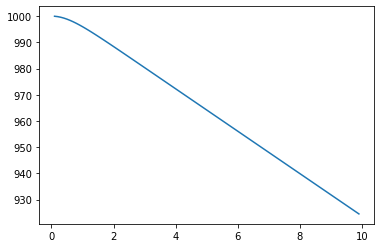

In [53]:
dt = 0.1
time_data = np.arange(0.1, 10, dt)
g = 9.81
m = 2.0
k = 0.3

# position_data = 1000 - 0.5 * g * time_data **2
# expected outcome fo symbolic regression: F = -m*g

position_data = 1000 - m/k * np.log(np.cosh(time_data * np.sqrt((g*k)/m)))
# expected output for symbolic regression: F = -m*g + k*v**2


print(position_data)

plt.plot(time_data, position_data)
plt.show

In [56]:
# Define the GNN model
class FreeFallGNN(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(FreeFallGNN, self).__init__(aggr='mean')
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, hidden_channels)  # Added hidden layer
        self.fc3 = nn.Linear(hidden_channels, out_channels)  # Additional layer
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # Passing the input through the neural network layers
        velocity_update = self.fc1(x)
        velocity_update = self.relu(velocity_update)
        velocity_update = self.fc2(velocity_update)
        velocity_update = self.relu(velocity_update)
        velocity_update = self.fc3(velocity_update)  # Predict velocity update as message
        return velocity_update

# Function to generate simulation data over time (with velocity updates)
def generate_fall_data_from_position(position_data, time_data, mass=2.0, acceleration=g, dt=dt):
    data_list = []

    velocity_data = np.zeros_like(position_data)
    velocity_data[0] = (position_data[1] - position_data[0]) / (time_data[1] - time_data[0])  # Forward difference for first datapoint

    # Compute velocity using central differences
    velocity_data[1:] = np.diff(position_data) / np.diff(time_data)  # v = dx/dt
    # velocity_data = np.insert(velocity_data, 0, velocity_data[0]) # Repeat first velocity value to not average out with 0    

    # Compute velocity updates explicitly
    velocity_update = np.diff(velocity_data)  # Compute delta v as v[i+1] - v[i]


    for i in range(len(velocity_update)):  # We stop before the last index
        # Calculate velocity update (delta v) as velocity[i+1] - velocity[i]
        # velocity_update = velocity_data[i+1] - velocity_data[i]

        x = torch.tensor([[position_data[i], velocity_data[i], mass]], dtype=torch.float)  # Node features (position, velocity, mass)
        y = torch.tensor([[velocity_update[i]]], dtype=torch.float)  # Ground truth velocity update (delta v)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)  # Self-loop (no interaction)
        data_list.append(Data(x=x, edge_index=edge_index, y=y))  # Only keep velocity update in the label (y)

    return data_list

def generate_fall_data_velocity_verlet(position_data, time_data, mass=1.0, acceleration=-9.81):
    data_list = []
    dt = np.diff(time_data).mean()  # Assume approximately constant time step

    # Initialize velocity using velocity Verlet
    velocity_data = np.zeros_like(position_data)
    velocity_data[0] = (position_data[1] - position_data[0]) / dt  # Forward difference for initial velocity

    for i in range(len(position_data) - 1):
        # Compute velocity using Velocity Verlet:
        velocity_half = velocity_data[i] + 0.5 * acceleration * dt  # Half-step velocity
        velocity_data[i+1] = velocity_half + 0.5 * acceleration * dt  # Full-step velocity
        velocity_update = velocity_data[i+1] - velocity_data[i]  # Δv = v[i+1] - v[i]

        # Create graph node data
        x = torch.tensor([[position_data[i], velocity_data[i], mass]], dtype=torch.float)  # Node features
        y = torch.tensor([velocity_update], dtype=torch.float)  # Velocity update (Δv)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)  # Self-loop

        data_list.append(Data(x=x, edge_index=edge_index, y=y))

    return data_list

def generate_fall_data_verlet_drag(position_data, time_data, mass, k, g):
    data_list = []
    dt = np.diff(time_data).mean()  # Assume approximately constant time step
    sqrt_gk_m = np.sqrt(g * k / mass)

    # Initialize velocity using given velocity function
    velocity_data = np.zeros_like(position_data)
    velocity_data[0] = sqrt_gk_m * np.tanh(time_data[0] * sqrt_gk_m)

    # Compute velocity using Velocity Verlet with drag
    acceleration = -g + (k/mass) * velocity_data ** 2  # Acceleration with drag
    velocity_half = velocity_data[:-1] + 0.5 * acceleration[:-1] * dt  # Half-step velocity
    new_acceleration = -g + (k/mass) * velocity_half ** 2  # Updated acceleration
    velocity_data[1:] = velocity_half + 0.5 * new_acceleration * dt  # Full-step velocity
    velocity_update = velocity_data[1:] - velocity_data[:-1]  # Δv = v[i+1] - v[i]

    # Node features: [position, velocity, velocity^2, mass]
    x = torch.tensor(np.vstack([time_data, position_data, velocity_data, velocity_data**2, np.full_like(time_data, mass)]).T, dtype=torch.float)

    # Target: Velocity update (Δv)
    # y = torch.tensor([velocity_update], dtype=torch.float)
    y = torch.tensor(np.append(velocity_update, 0), dtype=torch.float)

    # # Edge index: Connect node `i` to node `i+1`
    # edge_index = torch.tensor([[i, i+1] for i in range(len(time_data)-1)], dtype=torch.long).T   # Bidirectional edges

    edges = [[i, i+1] for i in range(len(time_data)-1)] + [[i+1, i] for i in range(len(time_data)-1)]
    edge_index = torch.tensor(edges, dtype=torch.long).T
    
    data_list.append(Data(x=x, edge_index=edge_index, y=y))


    return data_list


In [57]:
# Generate the simulation data from position data
# data_list = generate_fall_data_velocity_verlet(position_data, time_data)
data_list = generate_fall_data_verlet_drag(position_data, time_data, mass= m, k=k, g=g )
dataloader = DataLoader(data_list, batch_size=1, shuffle=False)  # Keep sequential order

# Initialize model, loss function, and optimizer
model = FreeFallGNN(in_channels=5, hidden_channels=8, out_channels=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
for epoch in range(10):
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        pred_velocity_update = model(data.x, data.edge_index)  # Predict velocity update
        loss = criterion(pred_velocity_update, data.y)  # Compare with ground truth velocity update
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.6f}")

# Output results
print("\nSimulation Results:")
for idx, data in enumerate(dataloader):
    with torch.no_grad():
        pred_velocity_update = model(data.x, data.edge_index)

        # Calculate the time step: Δt = time[i+1] - time[i]
        dt = np.diff(time_data).mean() # Time difference between current and next step

        # Calculate the predicted velocity: v[i+1] = v[i] + Δv
        predicted_velocity = data.x[:, 1] + pred_velocity_update

        # Calculate the predicted force: F = Δv / Δt
        force = pred_velocity_update / dt  # F = predicted Δv / Δt
        
        for t in range(len(pred_velocity_update)):
            print(f"Time Step {t}, Ground Truth Velocity Update: {data.y[t].item():.6f}, "
                  f"Predicted Velocity Update: {pred_velocity_update[t].item():.6f}, "
                  f"Predicted Force: {force[t].item():.6f}")


        # print(f"Ground Truth Velocity Update: {data.y[idx].item()}, Predicted Velocity Update: {pred_velocity_update[idx].item()}, Predicted Force: {force[idx].item():.6f}")

/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 1132.225220
Epoch 2, Loss: 1948.974365
Epoch 3, Loss: 562.199585
Epoch 4, Loss: 70.563957
Epoch 5, Loss: 3.901800
Epoch 6, Loss: 0.081693
Epoch 7, Loss: 0.055591
Epoch 8, Loss: 0.033468
Epoch 9, Loss: 0.020254
Epoch 10, Loss: 0.013391

Simulation Results:
Time Step 0, Ground Truth Velocity Update: -0.979952, Predicted Velocity Update: 0.015982, Predicted Force: 0.159815
Time Step 1, Ground Truth Velocity Update: -0.145676, Predicted Velocity Update: 0.015982, Predicted Force: 0.159815
Time Step 2, Ground Truth Velocity Update: 0.000000, Predicted Velocity Update: 0.015982, Predicted Force: 0.159815
Time Step 3, Ground Truth Velocity Update: 0.000000, Predicted Velocity Update: 0.015982, Predicted Force: 0.159815
Time Step 4, Ground Truth Velocity Update: 0.000000, Predicted Velocity Update: 0.015982, Predicted Force: 0.159815
Time Step 5, Ground Truth Velocity Update: 0.000000, Predicted Velocity Update: 0.015982, Predicted Force: 0.159815
Time Step 6, Ground Truth Veloc

In [52]:
print(f"First 20 Ground Truth Velocity Updates: {data.y[:20].numpy()}")

First 20 Ground Truth Velocity Updates: [-9.7995216e-01 -1.5998867e-04  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]


In [51]:
# Initialize empty lists to store all time step data
X_list = []
y_list = []

# Collect data from all batches in the dataloader
for batch in dataloader:
    with torch.no_grad():
        pred_velocity_update = model(batch.x, batch.edge_index)  # Shape: (99, 1)

        # Compute Δt for each time step
        dt = np.diff(time_data).mean()  # Constant time step assumption

        # Extract relevant features (for all time steps in the batch)
        X_batch = np.column_stack([
            batch.x[:, 1].numpy(),       # Velocity (v)
            (batch.x[:, 1]**2).numpy(),  # Velocity squared (v²)
            batch.x[:, 4].numpy(),       # Mass (m)
            np.full_like(batch.x[:, 4], g),  # Gravitational acceleration (g), constant
            np.full_like(batch.x[:, 4], k)   # Drag coefficient (k), constant
        ])

        # Target variable: Force (F = Δv / Δt), for all time steps
        y_batch = (pred_velocity_update.numpy().flatten() / dt)  # Ensure it's a 1D array

        # Append to the full dataset
        X_list.append(X_batch)
        y_list.append(y_batch)

# Convert lists to full numpy arrays
X = np.vstack(X_list)  # Shape: (num_samples, num_features)
y = np.concatenate(y_list)  # Shape: (num_samples,)

# Debugging: Check the shape
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (99, 5), Shape of y: (99,)


In [ ]:
# # Collect data for symbolic regression
# X_list = []
# y_list = []

# for data in dataloader:
#     X_list.append(data.x.numpy().flatten())  # Flatten to a single row per sample
#     y_list.append(data.y.numpy().item())  # Extract scalar target value

# # Convert to numpy arrays
# X = np.array(X_list)
# y = np.array(y_list)

ValueError: can only convert an array of size 1 to a Python scalar

In [49]:
equations = pysr.PySRRegressor(
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["square", "cube", "exp"],
    constraints={
        "+": (3, 3),   # Sum components should not be too complex.
        "*": (2, 2),   # Multiplication should only involve simple terms.
        "-": (3, 3),   # Allow subtraction but limit complexity.
        "/": (-1, 2),  # The numerator is unrestricted, denominator should be simple.
        "square": 2,   # Squaring should only act on a simple expression.
    },

    nested_constraints={
        "square": {"square": 0, "cube": 0, "exp": 0},  # Avoid deep nesting.
        "cube": {"square": 0, "cube": 0, "exp": 0}
    },

    complexity_of_operators={
        "+": 1,
        "-": 1,
        "*": 1,
        "/": 2,
        "square": 2,
        "cube":0,
    },

    complexity_of_constants=2  # Penalize constants slightly to encourage variable-based expressions.
)

In [50]:
equations.fit(X, y)

/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.350e+04
Head worker occupation: 19.0%
Progress: 223 / 600 total iterations (37.167%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.289e+02  1.594e+01  y = cube(x₄)
2           1.659e+00  4.927e+00  y = cube(-2.5325)
4           3.318e-01  8.047e-01  y = cube(-0.4712 - x₂)
10          3.316e-01  8.362e-05  y = exp(cube(-0.96142) / x₀) / -0.066267
11          3.312e-01  1.247e-03  y = exp((cube(x₄) - cube(x₃)) / x₁) / -0.066267
12          3.307e-01  1.542e-03  y = exp((x₀ - exp(cube(x₂))) / x₁) / -0.066267
13          4.674e-02  1.957e+00  y = (((cube(x₂) - x₀) / cube(x₂)) / cube(x₂)) / 0.98945
15          3.757e-02  1.092e-01  y = ((((cube(x₂) * cube(x₂)) - x₀) / cube(x₂)) / x₃) / cube(0....
                                  91245)
16          2.554e-02  3.859e-01  y = (((exp(cube(1.7093)) - x₀) / exp(x₂)) / x₃) / cube(0.90779.

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                           cube(x4)   
	1        6.536585                                   cube(-2.4711924)   
	2        0.272551            ((cube(x4) - x0) / cube(x2)) / cube(x2)   
	3        0.017733          ((-1.8557996 - x0) / cube(x2)) / cube(x2)   
	4  >>>>  0.945630  ((cube(x4) - x1) / exp(cube(x2))) / cube(2.744...   
	5        0.000726  ((cube(-4.021304) - x1) / exp(cube(x2))) / cub...   
	6        0.009732  ((x2 - (cube(x3) + x1)) / exp(cube(x2))) / cub...   
	7        0.000174  ((cube(-2.3866186) - (x1 + cube(x3))) / exp(cu...   
	8        0.003086  ((cube(x2 - x3) - (x1 + cube(x3))) / exp(cube(...   
	9        0.017720  ((((cube(x4) - x1) - (cube(x2) * cube(x3))) / ...   
	
	         loss  complexity  
	0  228.891310           1  
	1    0.331762           2  
	2    0.049233           9  
	3    0.048368          10  
	4    0.018788          11  
	5    0.018774          12  
	6    0.018592          13  
	7    0.018589          14  
	8    0.018532          15  
	9    0.017264          19  
]

In [48]:
print(equations)

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x4   
	1        0.060480                                        -0.15911523   
	2        6.511848                                   cube(-2.4711998)   
	3        0.574244                      (x1 * -0.00891216) / 549.3189   
	4        0.363623            ((cube(exp(x2)) - x0) / 18.507977) / x2   
	5        0.488200     ((cube(exp(x2)) - (x0 - x2)) / 18.507977) / x2   
	6  >>>>  0.726889  ((cube(exp(x2)) - (x0 + x3)) / 27.819866) / 1....   
	
	         loss  complexity  
	0  237.220370           1  
	1  223.298540           2  
	2    0.331762           3  
	3    0.018788           8  
	4    0.004387          12  
	5    0.001653          14  
	6    0.000799          15  
]
